In [1]:
require(tidyverse)
require(data.table)


Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: data.table

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose



In [23]:
compute_covar_score <- function(gwas_covars_df, covar_betas_df){    
    gwas_covars_df %>% 
    select(covar_betas_df %>% select(ID) %>% pull()) %>%
    data.matrix() %*% 
    (covar_betas_df %>% column_to_rownames('ID') %>% data.matrix()) %>%
    as.data.frame() %>%
    bind_cols(gwas_covars_df %>% select(FID, IID)) %>%
    select(FID, IID, BETA) %>%
    rename('covar_score' = 'BETA')
}

In [2]:
scores_f <- '/oak/stanford/groups/mrivas/projects/PRS/private_output/snpnet_PRS/cancer_20190303/8_score_all/cancer1060.sscore'
scores_df <- fread(cmd=paste0(
    'cat ', scores_f, " | awk -v OFS='\t' '{print $1, $2, $NF}'",
    ' | sed -e "s/^#//g"'
))


In [7]:
covar_betas_f <- '/oak/stanford/groups/mrivas/projects/PRS/private_output/snpnet_PRS/cancer_20190303/3_snpnet/cancer1060.covars.tsv.gz'
covar_betas_df <- fread(cmd=paste0(
    'zcat ', covar_betas_f, " | awk -v OFS='\t' '{print $1, $2}'"
))


In [10]:
gwas_covars_f <- '/oak/stanford/groups/mrivas/ukbb24983/sqc/ukb24983_GWAS_covar.pre.20190805.phe'
gwas_covars_df <- fread(gwas_covars_f)


In [50]:
phe_f <- '/oak/stanford/groups/mrivas/projects/PRS/private_output/snpnet_PRS/cancer_20190303/0_input/cancer1060.phe'
phe_df <- fread(phe_f)
colnames(phe_df) <- c('FID', 'IID', 'phe')


In [51]:
phe_df %>% head()

FID,IID,phe
<chr>,<chr>,<int>
-1,-1,1
-2,-2,1
-3,-3,-9
-4,-4,-9
-5,-5,1
-6,-6,1


In [52]:
all_df <- scores_df %>%
inner_join(
    compute_covar_score(gwas_covars_df, covar_betas_df),
    by=c('FID', 'IID')
) %>%
rename('geno_score' = 'SCORE1_SUM') %>%
mutate(FID = as.character(FID), IID = as.character(IID)) %>%
inner_join(
    phe_df, by=c('FID', 'IID')
)


In [53]:
all_df %>% dim()

[1] 488377      5

In [54]:
# pop_test_f <- '/oak/stanford/groups/mrivas/ukbb24983/sqc/population_stratification/split/ukb24983_white_british_test.phe'
pop_test_f <- '/oak/stanford/groups/mrivas/projects/PRS/private_output/snpnet_PRS/cancer_20190303/1_split/cancer1060.test'


In [55]:
pop_test_df <- fread(pop_test_f)
colnames(pop_test_df) <- c('FID', 'IID')


In [62]:
test_df <- all_df %>% 
inner_join(pop_test_df %>% mutate(FID = as.character(FID), IID = as.character(IID)), by=c('FID', 'IID')) %>%
mutate(
    phe = phe - 1,
    Percentile  = rank(-geno_score) / n(),
)


In [64]:
middle_df <- test_df %>% 
filter(0.4 < Percentile, Percentile <= 0.6) %>%
mutate(PRS = F) %>% 
select(FID, IID, phe, covar_score, PRS)    


In [77]:
compute_OR <- function(df, l_bin, u_bin, middle_df){
    stratified_df <- df %>% 
    filter(l_bin < Percentile, Percentile <= u_bin) %>%
    mutate(PRS = T) %>% select(FID, IID, phe, covar_score, PRS)    

    glmfit <- glm (
        phe ~ covar_score + as.factor(PRS),
        bind_rows(middle_df, stratified_df),
        family=binomial(link="logit")
    )
    
    LOR    <- summary(glmfit)$coefficients[3,1]
    se_LOR <- summary(glmfit)$coefficients[3,2]   
    OR     <- exp(LOR)    
    l_OR   <- exp(LOR - 1.96 * se_LOR)
    u_OR   <- exp(LOR + 1.96 * se_LOR)
        
    data.frame(
        l_bin = l_bin,
        u_bin = u_bin,
        OR   = OR,
        SE_LOR = se_LOR,
        l_OR = l_OR,
        u_OR = u_OR,
        OR_str = sprintf('%.3f (%.3f-%.3f)', OR, l_OR, u_OR)
    ) %>%
    mutate(OR_str = as.character(OR_str))
}


In [79]:
compute_tbl <- function(df, func){
    middle_df <- df %>% 
    filter(0.4 < Percentile, Percentile <= 0.6) %>%
    mutate(PRS = F) %>% 
    select(FID, IID, phe, covar_score, PRS)    

    bind_rows(
        func(df,   0, .01, middle_df),
        func(df, .01, .05, middle_df),
        lapply(2:19, function(x){
            func(df, (x-1)/20, x/20, middle_df)
        }),
        func(df, .95, .99, middle_df),
        func(df, .99, 1, middle_df),
    )    
}


In [87]:
generate_plot <- function(df, GBE_ID, phe_label, middle_line){
    p <- df %>%
    mutate(
        SE_LOR = if_else(SE_LOR > 10, NA_real_, SE_LOR),
        l_OR = if_else(SE_LOR > 10, NA_real_, l_OR),
        u_OR = if_else(SE_LOR > 10, NA_real_, u_OR),
#             l_SE_OR = exp(log(OR) - SE_LOR),
#             u_SE_OR = exp(log(OR) + SE_LOR),            
        x_ticks_labels = paste0('[', 100 * l_bin, '% - ', 100 * u_bin, '%]')
    ) %>%
    ggplot(aes(x=reorder(x_ticks_labels, -u_bin), y=OR)) +
    geom_point() + 
#         geom_errorbar(aes(ymin = l_SE_OR, ymax = u_SE_OR)) + 
    geom_errorbar(aes(ymin = l_OR, ymax = u_OR)) +         
#     geom_hline(yintercept = middle_line, color='gray')+
    theme_bw() + 
    theme(
        legend.position=c(.15, .9),
        axis.text.x = element_text(angle = 90, hjust = 1, vjust=.5)
    ) +
    labs(
        title = sprintf('%s (%s)', GBE_ID, phe_label),
        x = 'The polygenic risk score percentile',
        y = 'Odds ratio',
        color = 'Polygenic risk score'
    )
        
    return(p)
}

In [80]:
tbl <- compute_tbl(test_df, compute_OR)

In [93]:
tbl %>% fwrite('cancer1060.tsv', sep='\t')

In [89]:
p <- generate_plot(
    tbl, 'cancer1060', 'non-melanoma skin cancer', 
    test_df %>% select(phe) %>% pull() %>% mean()
)


Saving 6.67 x 6.67 in image


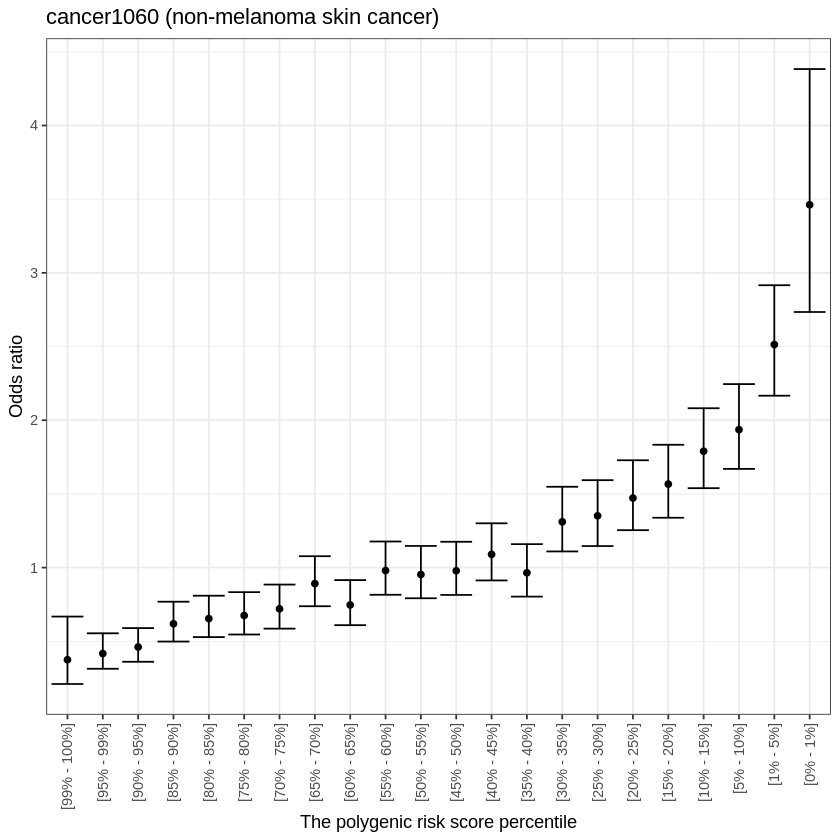

In [92]:
p + ggsave('cancer1060.png')

In [91]:
getwd()

[1] "/oak/stanford/groups/mrivas/users/ytanigaw/repos/rivas-lab/PRS/notebook/20191009_ASHG-2019-Agarwala-CTLA4"

Saving 6.67 x 6.67 in image


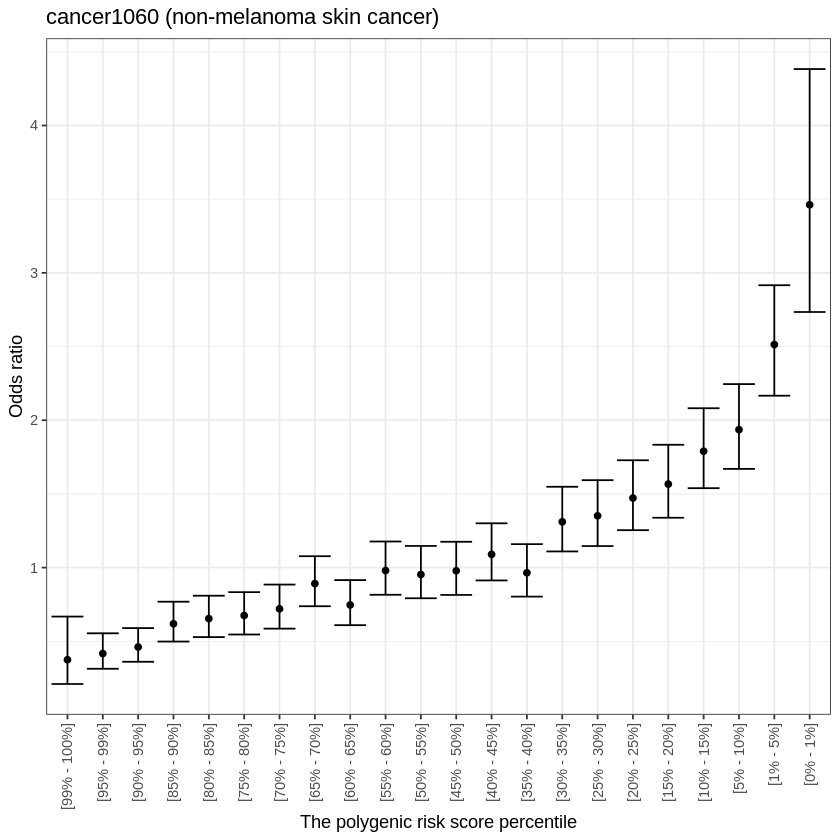

In [94]:
p + ggsave('cancer1060.pdf')